# 🛰️ Helicopter Landing Decision Support System (HLDSS) 🚁
---

The project aims to develop a system that can determine the best possible landing place for a helicopter in hard-to-reach terrain in order to evacuate critically injured or transport helicopter crew to the destination in the shortest and the safest possible way. 

 It will use images and data derived from COPERNICUS satellites to determine factors such as terrain slope, vegetation, obstacles, weather conditions and other environmental factors that may impact the safety of a landing.

Thereafter, it will compare the potential landing sites and select the one that meets the safety requirements and allows for the quickest and most efficient transport of the crew or injured person.

The project will use machine learning algorithms to continually improve the accuracy and reliability of the system. The system will be adaptable to different environments and terrains and will be able to provide real-time updates as conditions change.

It can be used in military  and civilian purpose. The military usage of this project include search and rescue missions, troop transport, and emergency medical evacuations. The system can also be used in civilian applications such as emergency medical services, disaster relief, and transportation of goods and people to far-distant locations.

# 📚 Technical issues 🔧
Section designed to install the necessary python packages

In [ ]:
# install packages
!pip install geopy
!pip install osmnx
!pip install opencv-python
!pip install openrouteservice

# Supporting functions implementations 👨‍💻
Section for author's functions

In [3]:
# imports
import folium
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from geopy import distance
import openrouteservice
import math
from folium import DivIcon

Upload here piece of map to analyze. 🗺️

In [4]:
# import files into Colaboratory
from google.colab import files
uploaded = files.upload()

Saving lasy.png to lasy.png


In [5]:
def HaversineDistance(Point1 : tuple, Point2 : tuple):
    # Convertion coordinates to radians
    lat1_rad = math.radians(Point1[0])
    lon1_rad = math.radians(Point1[1])
    lat2_rad = math.radians(Point2[0])
    lon2_rad = math.radians(Point2[1])
    
    # Computing difference between coordinates
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    # Length computing by using haversine formula
    a = math.sin(delta_lat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Convert result on kilometers (for the Earth radius equal 6371) 
    distance_km = 6371 * c
    
    return distance_km


In [6]:
def ShowMap(TopLeft, DownRight, Accident, LandingSite = None, zoom = 12, showMapEdges = False):
  centermap = ((TopLeft[0] + DownRight[0]) / 2, (TopLeft[1] + DownRight[1]) / 2)

  # Creating a map with a center between two points and a terrain layer
  mapa = folium.Map(location=centermap, zoom_start=zoom)

  # Adding a terrain layer
  folium.TileLayer("https://tile.opentopomap.org/{z}/{x}/{y}.png", 
                  attr='OpenTopoMap', name='OpenTopoMap', 
                  overlay=False, control=True).add_to(mapa)

  # Adding a layer of buildings (Stamen Toner)
  folium.TileLayer("https://stamen-tiles-{s}.a.ssl.fastly.net/toner/{z}/{x}/{y}.png",
                  attr='Stamen Design', name='Stamen Toner',
                  overlay=False, control=True).add_to(mapa)

  # Adding points on the map
  folium.Marker(Accident, popup='Accident',  icon=folium.Icon(color='red')).add_to(mapa)

  if showMapEdges:
    topRight= (TopLeft[0], DownRight[1])
    bottomLeft = (DownRight[0], TopLeft[1])

    folium.PolyLine([TopLeft, bottomLeft], color="black", weight=1, opacity=1).add_to(mapa)
    folium.PolyLine([bottomLeft, DownRight], color="black", weight=1, opacity=1).add_to(mapa)
    folium.PolyLine([DownRight, topRight], color="black", weight=1, opacity=1).add_to(mapa)
    folium.PolyLine([topRight, TopLeft], color="black", weight=1, opacity=1).add_to(mapa)

  if LandingSite is not None: 
    folium.Marker(LandingSite, popup='Landing Site',  icon=folium.Icon(color='green')).add_to(mapa)
    folium.PolyLine([Accident, LandingSite], color="blue", weight=2.5, opacity=1).add_to(mapa)
    distance = HaversineDistance(Accident,LandingSite)
    midpoint = ((LandingSite[0] + Accident[0]) / 2, (LandingSite[1] + Accident[1]) / 2)

    # Add label to line
    label_text = str(round(distance,3)) + " km"
    folium.Marker(
        location=midpoint,
        icon=DivIcon(
            icon_size=(75, 36),
            icon_anchor=(36, 36),
            html=f'<div style="font-size: 12pt; color: blue;">{label_text}</div>',
        ),
    ).add_to(mapa)


  # Adding a layer switch
  folium.LayerControl().add_to(mapa)

  return mapa

In [7]:
def TransformImageNoTreesArea(InputImageName, OutputImegeName, DarknessThreshold = 225):
  # Load image
  image = cv2.imread(InputImageName)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Convert image to HSV color space
  hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

  # Define the pixel darkness threshold
  darkness_threshold = DarknessThreshold

  # Apply thresholding to the V channel
  forest_mask = hsv_image[:, :, 2] < darkness_threshold
  meadow_mask = hsv_image[:, :, 2] >= darkness_threshold

  # Mark accessible and inaccessible terrain
  forest_color = (0, 0, 0)  
  meadow_color = (255, 255, 0) 

  marked_image = image.copy()
  marked_image[forest_mask] = forest_color
  marked_image[meadow_mask] = meadow_color

  # Print legend
  tree_patch = mpatches.Patch(color=(0,0,0), label='Not available')
  field_patch = mpatches.Patch(color=(1,1,0), label='Available')
  plt.legend(handles=[tree_patch, field_patch], loc='lower right')

  # Show image
  plt.imshow(marked_image)
  plt.title('Recollored map')
  plt.show()

  # Save image
  cv2.imwrite(OutputImegeName, cv2.cvtColor(marked_image, cv2.COLOR_RGB2BGR))

  return marked_image, meadow_mask

In [8]:
def ComputingSquares(InputImageName, top_left_coords, bottom_right_coords, square_size_meters):
  # LoadImage
  image = cv2.imread(InputImageName)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Calculate the distance between coordinates in meters
  width_meters = distance.distance((top_left_coords[0], top_left_coords[1]), (top_left_coords[0], bottom_right_coords[1])).m
  height_meters = distance.distance((top_left_coords[0], top_left_coords[1]), (bottom_right_coords[0], top_left_coords[1])).m

  # Calculate the number of grid squares based on the size of the square (25m)
  num_squares_x = int(np.ceil(width_meters / square_size_meters))
  num_squares_y = int(np.ceil(height_meters / square_size_meters))

  # Calculate the size of the square in pixels
  width_pixels, height_pixels = image.shape[1], image.shape[0]
  square_size_pixels_x = int(np.ceil(width_pixels / num_squares_x))
  square_size_pixels_y = int(np.ceil(height_pixels / num_squares_y))

  return square_size_pixels_x, square_size_pixels_y, width_pixels, height_pixels


In [9]:
def PrintGridMap(InputImageName, OutputImageName, square_size_pixels_x, square_size_pixels_y, width_pixels, height_pixels):
   # Load image
  image = cv2.imread(InputImageName)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Draw a grid on a photo
  grid_image = image.copy()
  for x in range(0, width_pixels, square_size_pixels_x):
      cv2.line(grid_image, (x, 0), (x, height_pixels), (255, 255, 255), 1)
  for y in range(0, height_pixels, square_size_pixels_y):
      cv2.line(grid_image, (0, y), (width_pixels, y), (255, 255, 255), 1)

  # Display grid image
  plt.imshow(grid_image)
  plt.title('Grid Map')
  plt.show()

  # Save image
  cv2.imwrite(OutputImageName, cv2.cvtColor(grid_image, cv2.COLOR_RGB2BGR))

  return grid_image

In [10]:
def FindClosesYellowSquare(point, grid_image, meadow_mask, square_size_pixels_x, square_size_pixels_y):
    height, width, _ = grid_image.shape
    min_distance = float('inf')
    closest_square = None
    
    for y in range(0, height, square_size_pixels_y):
        for x in range(0, width, square_size_pixels_x):
            square_mask = meadow_mask[y:y + square_size_pixels_y, x:x + square_size_pixels_x]
            if np.all(square_mask):
                square_center = (x + square_size_pixels_x // 2, y + square_size_pixels_y // 2)
                distance_to_point = np.sqrt((point[0] - square_center[0]) ** 2 + (point[1] - square_center[1]) ** 2)
                
                if distance_to_point < min_distance:
                    min_distance = distance_to_point
                    closest_square = (x, y)
    
    return closest_square

In [11]:
def PrintAccidentAndLandingPoints(InputImageName, OutputImageName, AccidentPoint, closest_yellow_square):
  # Load image
  image = cv2.imread(InputImageName)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Mark the point
  marked_point_image = image.copy()  
  cv2.circle(marked_point_image, AccidentPoint, 5, (207, 0, 234), -1)  

  x, y = closest_yellow_square
  cv2.rectangle(marked_point_image, (x, y), (x + square_size_pixels_x, y + square_size_pixels_y), (255, 0, 0), 2)

  # Display an image with a point and the nearest yellow square ( possible to land)
  plt.imshow(marked_point_image)
  plt.title('Accident and landing field marked')
  plt.show()

  # Save image
  cv2.imwrite(OutputImageName, cv2.cvtColor(marked_point_image, cv2.COLOR_RGB2BGR))

  return marked_point_image


In [12]:
def PixelToGeoCoords(pixel_coords, image_shape, top_left_coords, bottom_right_coords):
    pixel_x, pixel_y = pixel_coords
    height_pixels, width_pixels = image_shape[:2]
    
    # Calculate the ratio of latitude and longitude
    lat_range = bottom_right_coords[0] - top_left_coords[0]
    lon_range = bottom_right_coords[1] - top_left_coords[1]
    
    lat_ratio = lat_range / height_pixels
    lon_ratio = lon_range / width_pixels
    
    # Scale pixel coordinates to geographic coordinates
    geo_x = top_left_coords[0] + pixel_y * lat_ratio
    geo_y = top_left_coords[1] + pixel_x * lon_ratio
    
    return (geo_x, geo_y)

In [13]:
def GeoToPixelCoords(geo_coords, image_shape, top_left_coords, bottom_right_coords):
    geo_x, geo_y = geo_coords
    height_pixels, width_pixels = image_shape[:2]

    # Calculate the ratio of latitude and longitude
    lat_range = bottom_right_coords[0] - top_left_coords[0]
    lon_range = bottom_right_coords[1] - top_left_coords[1]

    lat_ratio = lat_range / height_pixels
    lon_ratio = lon_range / width_pixels

    # Scale geographic coordinates to pixel coordinates
    pixel_y = int(round((geo_x - top_left_coords[0]) / lat_ratio))
    pixel_x = int(round((geo_y - top_left_coords[1]) / lon_ratio))

    return (pixel_x, pixel_y)

# Scenario
Situational description, presenting the implemented solutions.

## CASEVAC (Casualty evacuation) 🆘 🤕🩸 🆘

One day, at 2:00 PM, during a military mission, a helicopter with crew and soldiers on board crashed. After a brief analysis of the situation, the commander decided on an immediate evacuation of the injured from the battlefield.

Due to the difficult terrain it was necessary to find a suitable landing spot that would allow for a safe landing of the helicopter and the safe transport of the injured to the hospital.

At this point, the algorithm for finding the best landing spot began to play an important role. The algorithm was based on the analysis of satellite data and drone images, which were transmitted to the command center.

As a result, the rescue team received precise information about the terrain, slope angles, obstacles, and weather conditions. The HLDSS selected two potential landing spots that met the requirements for size of, shape, and safety.

After the algorithm indicated the best landing spot, the rescue team landed the helicopter in a safe location and began transporting the injured to the hospital.

Thanks to the use of the algorithm, the rescue operation proceeded smoothly and safely, allowing for a quick and effective evacuation of the injured from the battlefield. The algorithm for finding the best landing spot played a crucial role in the entire rescue operation.

# Proof of concept 💡

Data from COPERNICUS can be used to determine the optimal helicopter landing site for the prototype project. It will identify the closest area to the target location that is free of trees or other obstacles that would prevent the helicopter from landing.

## 🧾 Required data

In order to run the scenario, you will need a map fragment defining the wooded area available in COPERNICUS data, as well as the coordinates of the upper left corner of the map fragment and the bottom right corner of the map.

In [43]:
# const of used data
LEFT_TOP = (49.242483, 22.623940)
RIGHT_BOTTOM = (49.195615, 22.716980)
SOURCE_IMAGE_NAME = 'forest.png'
RECOLLORED_IMAGE_NAME = 'forest_collored.jpg'
GRID_MAP_NAME = 'grid_image.jpg'
MARKED_MAP_NAME = "marked_map.jpg"
MARKED_ORIGINAL_MAP_NAME = "marked_original_map.jpg"

In [15]:
# variables
AccidentCoords = (49.23486218699187, 22.6315662295082)

Receiving message with coordinates where accident happened.

In [44]:
ShowMap(LEFT_TOP, RIGHT_BOTTOM, AccidentCoords, showMapEdges=False)

Marking delivered piece of map derived from satellites by black rectangle. It will be proceeding and analyzing in next steps.

In [55]:
ShowMap(LEFT_TOP, RIGHT_BOTTOM, AccidentCoords, zoom=14, showMapEdges=True)

Finding places without trees that are possible to land (the properties of aerial vehicle are not included in this step). By using different type of layers, we can increase precise to determine available terrains.

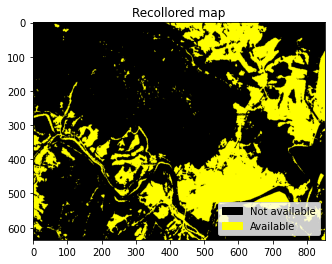

In [47]:
marked_image, meadow_mask = TransformImageNoTreesArea(SOURCE_IMAGE_NAME, RECOLLORED_IMAGE_NAME)

The next step is to consider the vehicle dimensions and plot the appropriate size of grid on the map.

In [48]:
ComputingSquares(RECOLLORED_IMAGE_NAME, LEFT_TOP, RIGHT_BOTTOM, 25)

(4, 4, 854, 636)

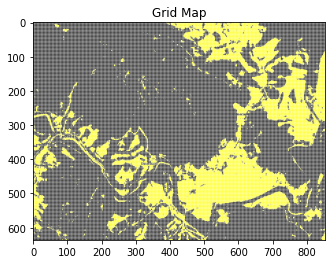

In [49]:
square_size_pixels_x, square_size_pixels_y, width_pixels, height_pixels = ComputingSquares(RECOLLORED_IMAGE_NAME, LEFT_TOP, RIGHT_BOTTOM, 25)
grid_image = PrintGridMap(RECOLLORED_IMAGE_NAME, GRID_MAP_NAME, square_size_pixels_x, square_size_pixels_y, width_pixels, height_pixels)

After the analysis, there is a result effect in the shape of detected the safest available landing zone marked on map. 

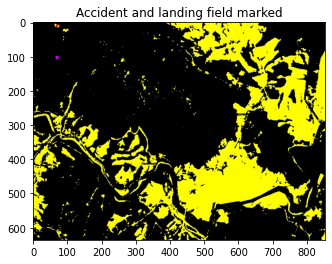

In [50]:
pixcel_accident = GeoToPixelCoords(AccidentCoords, marked_image.shape, LEFT_TOP, RIGHT_BOTTOM)
pixcel_landing = FindClosesYellowSquare(pixcel_accident, marked_image, meadow_mask, square_size_pixels_x, square_size_pixels_y)
marked_point_image = PrintAccidentAndLandingPoints(RECOLLORED_IMAGE_NAME, MARKED_MAP_NAME, pixcel_accident, pixcel_landing)

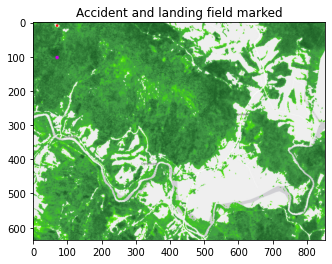

In [51]:
marked_point_original_image = PrintAccidentAndLandingPoints(SOURCE_IMAGE_NAME, MARKED_ORIGINAL_MAP_NAME, pixcel_accident, pixcel_landing)

For the better view the accident location and the safest available landing ground is plotted on the map below. 📌

In [52]:
LandingGeoCoords = PixelToGeoCoords(pixcel_landing, marked_image.shape, LEFT_TOP, RIGHT_BOTTOM)

In [53]:
ShowMap(LEFT_TOP, RIGHT_BOTTOM, AccidentCoords, LandingGeoCoords,14,showMapEdges=True)

In [54]:
# download all images files from Colaboratory
from google.colab import files
files.download(SOURCE_IMAGE_NAME)
files.download(RECOLLORED_IMAGE_NAME)
files.download(GRID_MAP_NAME)
files.download(MARKED_MAP_NAME)
files.download(MARKED_ORIGINAL_MAP_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>